Model şu cihazda çalışacak: cuda


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,3.794000,0.150442,0.676871,0.588816,0.676871,0.610516,0.561169
2,0.154500,0.106582,0.838435,0.834337,0.838435,0.833725,0.835856
3,0.082000,0.075136,0.912415,0.912011,0.912415,0.909617,0.910659
4,0.072700,0.062922,0.916667,0.914857,0.916667,0.914929,0.927449
5,0.057500,0.053390,0.934524,0.934264,0.934524,0.934155,0.928017
6,0.049600,0.053282,0.931122,0.931562,0.931122,0.931076,0.925765
7,0.044600,0.050872,0.942177,0.942922,0.942177,0.941859,0.932022
8,0.043300,0.046337,0.942177,0.942969,0.942177,0.941717,0.929224
9,0.041600,0.047044,0.937925,0.937978,0.937925,0.937743,0.931953
10,0.037100,0.045614,0.942177,0.942413,0.942177,0.941801,0.931999


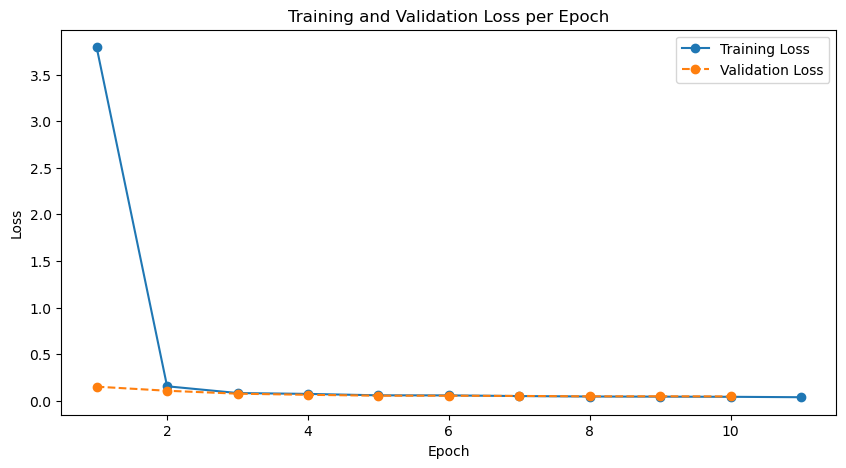

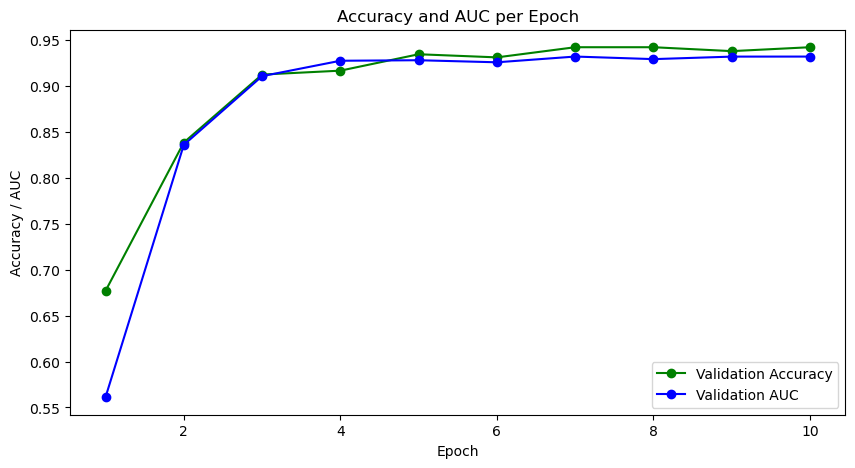

<Figure size 800x800 with 0 Axes>

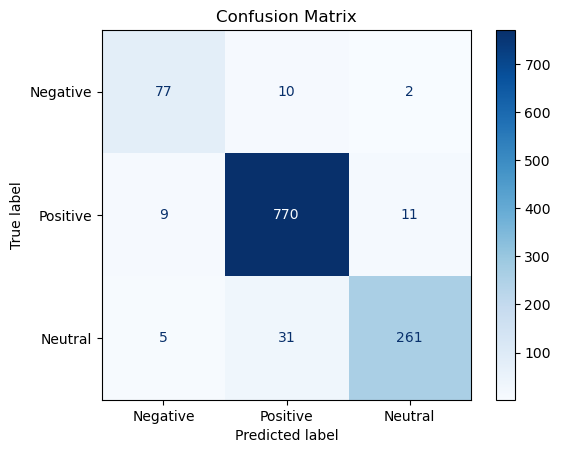

   test_loss  test_accuracy  test_precision  test_recall   test_f1  test_auc  \
0   0.045614       0.942177        0.942413     0.942177  0.941801  0.931999   

   test_runtime  test_samples_per_second  test_steps_per_second  
0         39.88                   29.488                  0.928  
T5 modeli ile eğitim ve değerlendirme tamamlandı!


In [4]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt

# GPU kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model şu cihazda çalışacak: {device}")

# Veri setini yükleme
data_cleaned = pd.read_csv("sentiment_analysis_results.csv")

# Etiketleri sayısal değere dönüştürme
label_map = {'positive': 'positive', 'negative': 'negative', 'neutral': 'neutral'}
data_cleaned['labels'] = data_cleaned['sentiment'].map(label_map)

# Eğitim ve test setlerine ayırma
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_cleaned['Yorum Temiz'].tolist(),
    data_cleaned['labels'].tolist(),
    test_size=0.2,
    random_state=42
)

# Model ismi ve Tokenizer tanımı (T5 modeli seçildi)
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizasyon fonksiyonu
def tokenize_function(texts, labels):
    inputs = [f"sentiment: {text}" for text in texts]
    model_inputs = tokenizer(inputs, padding="max_length", truncation=True, max_length=256)
    labels = tokenizer(labels, padding="max_length", truncation=True, max_length=5)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_encodings = tokenize_function(train_texts, train_labels)
test_encodings = tokenize_function(test_texts, test_labels)

train_dataset = Dataset.from_dict(train_encodings)
test_dataset = Dataset.from_dict(test_encodings)

# Modeli tanımlama
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)

# Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.1,
    logging_dir="./logs",
    eval_strategy="epoch",
    fp16=True if torch.cuda.is_available() else False,
)

# Performans metriklerini hesaplama fonksiyonu
def compute_metrics(pred):
    preds = pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.argmax(preds, axis=-1)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(pred.label_ids, skip_special_tokens=True)
    precision, recall, f1, _ = precision_recall_fscore_support(decoded_labels, decoded_preds, average='weighted', zero_division=0)
    acc = accuracy_score(decoded_labels, decoded_preds)
    try:
        auc = roc_auc_score([1 if label == 'positive' else 0 for label in decoded_labels],
                            [1 if pred == 'positive' else 0 for pred in decoded_preds])
    except ValueError:
        auc = 0.5
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

# Trainer objesi ve model eğitimi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# Eğitim sırasında kaydedilen metrikleri alın
metrics = trainer.state.log_history

# Loss ve Accuracy metriklerini ayıkla
training_loss = [m.get("loss", None) for m in metrics if "loss" in m]
validation_loss = [m.get("eval_loss", None) for m in metrics if "eval_loss" in m]
accuracy = [m.get("eval_accuracy", None) for m in metrics if "eval_accuracy" in m]
auc_values = [m.get("eval_auc", None) for m in metrics if "eval_auc" in m]

# Loss Grafiği
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(training_loss) + 1), training_loss, label="Training Loss", marker='o')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label="Validation Loss", marker='o', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig("loss_per_epoch.png")
plt.show()

# Accuracy ve AUC Grafiği
valid_accuracy = [acc for acc in accuracy if acc is not None]
valid_auc = [auc for auc in auc_values if auc is not None]
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_accuracy) + 1), valid_accuracy, label="Validation Accuracy", color="green", marker='o')
plt.plot(range(1, len(valid_auc) + 1), valid_auc, label="Validation AUC", color="blue", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy / AUC")
plt.title("Accuracy and AUC per Epoch")
plt.legend()
plt.savefig("accuracy_auc_per_epoch.png")
plt.show()

# Confusion Matrix
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
if isinstance(preds, tuple):
    preds = preds[0]
pred_labels = np.argmax(preds, axis=-1)
decoded_labels = tokenizer.batch_decode(pred_labels, skip_special_tokens=True)
cm = confusion_matrix(test_labels, decoded_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive", "Neutral"])
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# Metrix tablosunu yazdırma
results_df = pd.DataFrame(predictions.metrics, index=[0])
results_df.to_csv("t5_model_results.csv", index=False)
print(results_df)

print("T5 modeli ile eğitim ve değerlendirme tamamlandı!")
